<a href="https://kritikseth.github.io/ipynbtagredirect" target="_parent"><img src="https://raw.githack.com/kritikseth/kritikseth/master/assets/icons/kritik_ipynbtagredirect.svg" alt="Kritik Seth"/></a>

In [1]:
import pandas as pd
import numpy as np

import os
import cv2
from PIL import Image

import keras
import tensorflow as tf
from tqdm.keras import TqdmCallback

from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [2]:
def plot_train_val_metrics(history):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Accuracy', 'Loss'))

    fig.add_trace(go.Scatter(y=history.history['acc'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['val_acc'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=1)

    fig.add_trace(go.Scatter(y=history.history['loss'],
                            mode='lines',
                            name='Train',
                            marker_color='#ff414d',
                            opacity=0.75),
                row=1, col=2)
    fig.add_trace(go.Scatter(y=history.history['val_loss'],
                            mode='lines',
                            name='Validation',
                            marker_color='#1f4068',
                            opacity=0.75),
                row=1, col=2)

    fig.show()

In [3]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [5]:
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

In [7]:
y_train_ohe = keras.utils.to_categorical(y_train)
y_test_ohe = keras.utils.to_categorical(y_test)

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix

In [9]:
val_split = X_test.shape[0]/(X_train.shape[0]+X_test.shape[0])

train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=10,
                                   zoom_range=0.10,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10,
                                   shear_range=0.10,
                                   fill_mode='nearest',
                                   validation_split=val_split)

test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
BATCH_SIZE = 50
img_rows, img_cols = (28, 28)
input_shape = (img_rows, img_cols, 1)
TRAIN_STEPS_PER_EPOCH = X_train.shape[0]*(1-val_split)//BATCH_SIZE
VAL_STEPS_PER_EPOCH = X_train.shape[0]*val_split//BATCH_SIZE

train_aug = train_datagen.flow(X_train,
                               y_train_ohe,
                               batch_size=BATCH_SIZE,
                               subset='training',
                               shuffle=False,
                               seed=42)

valid_aug = train_datagen.flow(X_train,
                               y_train_ohe,
                               batch_size=BATCH_SIZE,
                               subset='validation',
                               shuffle=False,
                               seed=42)


test_aug = train_datagen.flow(X_test,
                              y_test_ohe,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              seed=42)

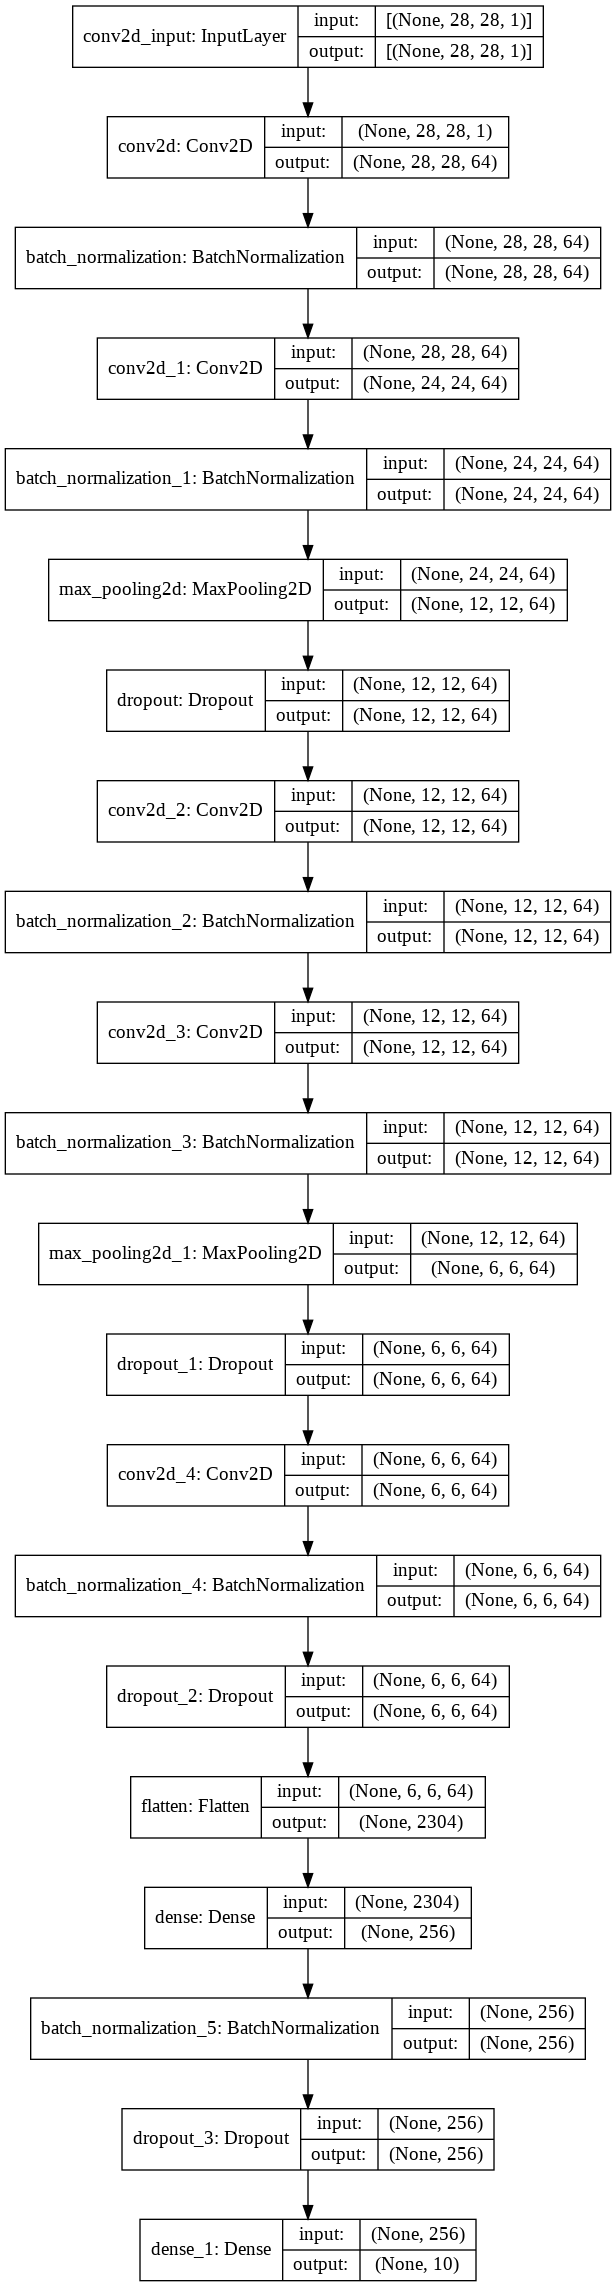

In [11]:
cnn = keras.models.Sequential()

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu', padding='same', input_shape=input_shape))
cnn.add(keras.layers.BatchNormalization())

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(units=256, activation='relu'))
cnn.add(keras.layers.BatchNormalization())
cnn.add(keras.layers.Dropout(0.25))

cnn.add(keras.layers.Dense(units=10, activation='softmax'))

keras.utils.plot_model(cnn, show_shapes=True, show_layer_names=True)

In [12]:
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [13]:
ch = tf.keras.callbacks.ModelCheckpoint(
    filepath='mnist_model.h5',
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True
)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_acc',
    min_delta=0.003,
    patience=15,
    mode='max',
    restore_best_weights=True,
)

lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.05,
    patience=3,
    mode='max',
)

In [14]:
history = cnn.fit(train_aug, validation_data=valid_aug, epochs=50, verbose=0,
                    callbacks=[ch, es, lr, TqdmCallback(verbose=1)])

In [15]:
cnn.evaluate(test_aug)

200/200 [==============================] - 4s 21ms/step - loss: 0.0177 - acc: 0.9942


[0.017741646617650986, 0.9941999912261963]

In [16]:
plot_train_val_metrics(history)

In [17]:
cnn.save('mnist_model.h5')

<h1 style="background-color:#2d6187;color:white;font-family:Arial;font-size:350%;text-align:center">Creating Flask Application</h1>

In [18]:
!pip install flask gevent requests pillow flask-ngrok

     |████████████████████████████████| 5.5MB 9.6MB/s 
     |████████████████████████████████| 163kB 45.4MB/s 
     |████████████████████████████████| 245kB 42.6MB/s 


In [19]:
html = '''<!DOCTYPE HTML>
<!DOCTYPE HTML>
<html lang="en">
    <head>
        <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
        <title>MNIST- Canvas</title>
        <link rel="stylesheet" href="https://codepen.io/chriddyp/pen/bWLwgP.css">
    </head>

    <body>

        <br>
        <center><h1 id="title">MNIST - Canvas</h1></center>
        <br>
        <form name="image_form" action="/" method="POST" enctype="multipart/form-data">
            <div style="width: 800px; margin: 0 auto; justify-content: center; align-items: center">

                <div style="width: 280px; height: 280px; float:left; border:1px solid rgb(100, 100, 100); font-size: 280px; line-height: 280px; text-align: center">
                    <img src="" id="preview" style="width: 280px; height: 280px; float:left;">
                </div>

                <div style="width: 230px; height: 280px; float: left; position:relative">
                    <input type="file" name="file" id="filetag" accept="image/png, image/jpeg, image/jpg" style="width: 75%; position:absolute; top: 30%; left: 12%">
                    <input id="predict" class="cust_button" type="submit" value="Upload" style="width: 75%; position:absolute; top: 50%; left: 12%"/> 
                </div>

                <div style="width: 280px; height: 280px; float:left; border:1px solid black; font-size: 280px; line-height: 280px; text-align: center">
                    <span id="num" style="">{{number}}</span>
                </div>
            </div>
        </form>
    </body>

    <script>
        var fileTag = document.getElementById("filetag"),
            preview = document.getElementById("preview");
            
        fileTag.addEventListener("change", function() {
        changeImage(this);
        });

        function changeImage(input) {
        var reader;

        if (input.files && input.files[0]) {
            reader = new FileReader();

            reader.onload = function(e) {
            preview.setAttribute('src', e.target.result);
            }

            reader.readAsDataURL(input.files[0]);
        }
        }
    </script>

</html>
'''

In [20]:
!mkdir templates
!mkdir uploads
HTML_file = open('/content/templates/index.html', 'w')
HTML_file.write(html)
HTML_file.close()

In [21]:
%%writefile app.py

import os
import cv2
import keras
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import numpy as np

app = Flask(__name__, static_folder='/content/templates')
run_with_ngrok(app)

app.config['UPLOADS'] = 'uploads'

cnn = keras.models.load_model('/content/mnist_model.h5')

def process(file):
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28))
    image = np.resize(image, (1, 28, 28, 1))
    image = image/255.0
    image = 1-image
    return image

@app.route('/')
def index():
    return render_template('index.html')

@app.route('/', methods=['GET', 'POST'])
def predict():
    if request.method == 'POST':
        file = request.files['file']
        filepath = os.path.join(app.config['UPLOADS'], file.filename)
        file.save(filepath)
        image = process(filepath)
        prediction = cnn.predict_classes(image)
    return render_template('index.html', number=prediction[0])

if __name__ == '__main__':
    app.run()

Writing app.py


In [ ]:
!python app.py

2021-01-28 12:20:47.558233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-01-28 12:20:49.692836: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-01-28 12:20:49.693803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-01-28 12:20:49.696830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-01-28 12:20:49.697492: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.562GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-01-28 12:20:49.697544: I tensorflow/stream_executor/platform/default/dso_loa